<a href="https://colab.research.google.com/github/allythe/Alg_Struct_of_Data_FALT2022/blob/main/StatisticalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief Outline

This script performs the **statistical analysis** of results obtained after running the `Algorithms.ipynb` file.  

It includes:

- Displaying **boxplots** of accuracy metrics.
- Performing **pairwise statistical tests** to compare methods.

The analysis is divided into the following parts:

1. **Compute accuracy metrics** – calculate quality measures for all algorithms.  
2. **Draw boxplots** – visualize the distribution of quality metrics across all algorithms.  
3. **Pairwise statistical comparison** – run Mann-Whitney U test with Holm-Bonferroni correction.  
4. **Draw images with predicted horizons** – visualize horizon predictions for selected methods.  
5. **Draw ground truth horizons** – overlay the GT horizon on a single frame from each video for reference.

In [21]:
import os
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

In [1]:
from google.colab import drive
drive.mount("/content/drive/")
!ls /content/drive/MyDrive/MIUN/QRD/implementation/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Algorithms.ipynb  DatasetFromCVAT.ipynb        images	videos
Analysis.ipynb	  horizon_coordinates_all.csv  results


# Compute accuracy metrics

In [3]:
def compute_accuracy_metrics(gt_csv, results_csv, img_name):
    gt_df = pd.read_csv(gt_csv)
    pred_df = pd.read_csv(results_csv)

    img_path = os.path.join(images_folder, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f" Could not load {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img_rgb.shape[:2]

    # GT polyline points
    gt_points = gt_df[gt_df['image_name'] == img_name][['x', 'y']].values
    gt_points = gt_points[np.argsort(gt_points[:, 0])]

    # Predicted horizon line
    pred_row = pred_df[pred_df['image_name'] == img_name].iloc[0]
    if pd.isna(pred_row['x1']):
        print(" No predicted horizon for this image.")
        return
    x1, y1, x2, y2 = pred_row[['x1', 'y1', 'x2', 'y2']].astype(float)
    pred_angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))


    # Compute the number of columns (x-span) for each segment
    segment_spans = np.diff(gt_points[:, 0])  # x2 - x1 for each segment
    total_span = np.sum(segment_spans)

    # Compute weighted mean angle deviation based on x-span
    angle_devs = []
    for i in range(len(gt_points) - 1):
        gx1, gy1 = gt_points[i]
        gx2, gy2 = gt_points[i + 1]
        segment_angle = np.degrees(np.arctan2(gy2 - gy1, gx2 - gx1))
        angle_dev = abs(segment_angle - pred_angle)
        weight = segment_spans[i] / total_span if total_span > 0 else 0
        angle_devs.append(angle_dev * weight)

    mean_angle_dev = np.sum(angle_devs)

    # Interpolate predicted line over overlapping x-range for height deviation
    overlap_x_start = max(min(gt_points[:, 0]), min(x1, x2))
    overlap_x_end = min(max(gt_points[:, 0]), max(x1, x2))
    if overlap_x_end <= overlap_x_start:
        mean_height_dev = np.nan
        coverage_percent = 0
    else:
        overlap_xs = np.linspace(overlap_x_start, overlap_x_end, 200)
        gt_y_interp = np.interp(overlap_xs, gt_points[:, 0], gt_points[:, 1])
        m_pred = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else None
        b_pred = y1 - m_pred * x1 if m_pred is not None else None
        pred_y_interp = m_pred * overlap_xs + b_pred if m_pred is not None else np.full_like(overlap_xs, np.nan)
        mask = ~np.isnan(pred_y_interp)
        mean_height_dev = np.mean(np.abs(gt_y_interp[mask] - pred_y_interp[mask])) if np.any(mask) else np.nan
        coverage_percent = 100 * (overlap_x_end - overlap_x_start) / width
        mean_height_perc_dev = mean_height_dev/ height

    # Draw GT horizon (blue)
    for i in range(len(gt_points) - 1):
        cv2.line(img_rgb,
                 (int(gt_points[i, 0]), int(gt_points[i, 1])),
                 (int(gt_points[i + 1, 0]), int(gt_points[i + 1, 1])),
                 (0, 0, 255), 2)
    # Draw predicted horizon (red)
    cv2.line(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)

    return {
        "image_name": img_name,
        "mean_height_deviation": mean_height_dev,
        "predicted_coverage_percent": coverage_percent,
        "mean_angle_deviation": mean_angle_dev,
        "mean_height_perc_dev": mean_height_perc_dev
    }

In [4]:
gt_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/horizon_coordinates_all.csv"
results_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_hc_results.csv"
images_folder = "/content/drive/MyDrive/MIUN/QRD/implementation/images"

result = compute_accuracy_metrics(gt_csv, results_csv, "boat_ice_1_img_024245.jpeg")
print(result)

{'image_name': 'boat_ice_1_img_024245.jpeg', 'mean_height_deviation': np.float64(1.5631777343749829), 'predicted_coverage_percent': 38.0078125, 'mean_angle_deviation': np.float64(0.06020530865809955), 'mean_height_perc_dev': np.float64(0.0010855400933159603)}


## Compute accuracy metrics for H-HC horizon detection results

In [5]:
def compute_accuracy_metrics_all_img(gt_csv, results_csv, images_folder, save_csv_path):
    gt_df = pd.read_csv(gt_csv)
    pred_df = pd.read_csv(results_csv)

    common_imgs = set(gt_df['image_name']).intersection(pred_df['image_name'])
    print(f"Processing {len(common_imgs)} images...")

    all_results = []

    for img_name in tqdm(sorted(common_imgs)):
        try:
          result = compute_accuracy_metrics(gt_csv, results_csv, img_name)
        except:
          result = None
        if result is not None:
            time_row = pred_df[pred_df['image_name'] == img_name]
            if not time_row.empty:
                result["time_sec"] = float(time_row.iloc[0]["time_sec"])
            else:
                result["time_sec"] = None
            all_results.append(result)

    df_results = pd.DataFrame(all_results)
    return df_results

In [7]:
gt_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/horizon_coordinates_all.csv"
images_folder = "/content/drive/MyDrive/MIUN/QRD/implementation/images"

results_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_hc_results.csv"
save_csv_path = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_hc_analysis_results.csv"

df_results_h_hc = compute_accuracy_metrics_all_img(gt_csv, results_csv, images_folder, save_csv_path)
df_results_h_hc.to_csv(save_csv_path, index=False)
print(f" All results saved to {save_csv_path}")

Processing 717 images...


 92%|█████████▏| 662/717 [05:04<00:05,  9.17it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000455.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000460.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000470.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000480.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000490.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000500.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000505.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000510.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000515.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000525.jpeg
 Could not load /con

100%|██████████| 717/717 [05:41<00:00,  2.10it/s]

 All results saved to /content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_hc_analysis_results.csv


In [8]:
df_results_h_hc.describe()

mean_height_deviation  predicted_coverage_percent  \
count             698.000000                  698.000000   
mean               64.240524                   56.683489   
std               121.834125                   29.179420   
min                 0.166441                    2.617188   
25%                 4.761061                   26.455078   
50%                 8.475462                   56.692708   
75%                55.013710                   83.489583   
max               854.671211                   99.947917   

       mean_angle_deviation  mean_height_perc_dev    time_sec  
count            698.000000            698.000000  698.000000  
mean               2.585000              0.062232    0.436798  
std                9.036696              0.118358    0.190122  
min                0.000224              0.000231    0.078000  
25%                0.208666              0.003965    0.322250  
50%                0.457908              0.006542    0.408000  
75%                1.424530              0.055846    0.513000  
max               84.818135              0.653157    1.349000

## Compute accuracy metrics for H-LSC horizon detection results

In [9]:
results_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_lsc_results.csv"
save_csv_path = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_lsc_analysis_results.csv"

df_results_h_lsc = compute_accuracy_metrics_all_img(gt_csv, results_csv, images_folder, save_csv_path)
df_results_h_lsc.to_csv(save_csv_path, index=False)
print(f" All results saved to {save_csv_path}")


Processing 717 images...


 93%|█████████▎| 665/717 [00:21<00:00, 70.06it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000455.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000460.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000470.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000480.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000490.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000500.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000505.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000510.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000515.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000525.jpeg
 Could not load /con

100%|██████████| 717/717 [00:22<00:00, 31.84it/s]


 All results saved to /content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_lsc_analysis_results.csv


In [10]:
df_results_h_lsc.describe()

mean_height_deviation  predicted_coverage_percent  \
count             698.000000                  698.000000   
mean              200.604159                   99.938153   
std               102.701336                    0.273256   
min                 1.685329                   92.744531   
25%               122.411424                   99.947917   
50%               210.778156                   99.947917   
75%               262.268986                   99.960938   
max               518.556276                   99.960938   

       mean_angle_deviation  mean_height_perc_dev    time_sec  
count            698.000000            698.000000  698.000000  
mean               4.343843              0.184220    0.116163  
std                3.410385              0.109062    0.056984  
min                0.000413              0.001170    0.034000  
25%                1.545603              0.100313    0.077000  
50%                3.427881              0.168493    0.102500  
75%                6.879188              0.267470    0.157000  
max               17.067471              0.534123    0.453000

## Compute accuracy metrics for H-MED horizon detection results

In [11]:
results_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_med_results.csv"
save_csv_path = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_med_analysis_results.csv"

df_results_h_med = compute_accuracy_metrics_all_img(gt_csv, results_csv, images_folder, save_csv_path)
df_results_h_med.to_csv(save_csv_path, index=False)
print(f" All results saved to {save_csv_path}")

Processing 717 images...


 92%|█████████▏| 660/717 [00:21<00:00, 65.59it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000455.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000460.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000470.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000480.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000490.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000500.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000505.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000510.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000515.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000525.jpeg
 Could not load /con

100%|██████████| 717/717 [00:22<00:00, 31.97it/s]


 All results saved to /content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_med_analysis_results.csv


In [12]:
df_results_h_med.describe()

mean_height_deviation  predicted_coverage_percent  \
count             698.000000                  698.000000   
mean              198.165678                   99.887363   
std               121.760017                    0.273971   
min                 2.453753                   92.705469   
25%                96.358038                   99.895833   
50%               169.934580                   99.895833   
75%               295.217836                   99.921875   
max               483.536458                   99.921875   

       mean_angle_deviation  mean_height_perc_dev    time_sec  
count            698.000000            698.000000  698.000000  
mean               3.607278              0.186413    0.130024  
std                2.674100              0.129966    0.060380  
min                0.024174              0.001871    0.040000  
25%                1.516235              0.072760    0.089000  
50%                3.084697              0.151667    0.127000  
75%                5.137343              0.286119    0.167000  
max               12.623269              0.537970    0.511000

## Compute accuracy metrics for H-COV-LUM horizon detection results

In [13]:
results_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_cov_lum_results.csv"
save_csv_path = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_cov_lum_analysis_results.csv"

df_results_h_cov_lum = compute_accuracy_metrics_all_img(gt_csv, results_csv, images_folder, save_csv_path)
df_results_h_cov_lum.to_csv(save_csv_path, index=False)
print(f" All results saved to {save_csv_path}")

Processing 717 images...


 91%|█████████ | 652/717 [00:23<00:04, 13.89it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000455.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000460.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000470.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000480.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000490.jpeg


 92%|█████████▏| 658/717 [00:23<00:03, 19.32it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000500.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000505.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000510.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000515.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000525.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000530.jpeg


 93%|█████████▎| 664/717 [00:23<00:02, 22.71it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000535.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000540.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000550.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000560.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000570.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000580.jpeg


 93%|█████████▎| 667/717 [00:24<00:02, 22.83it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000590.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000600.jpeg


100%|██████████| 717/717 [00:26<00:00, 26.59it/s]


 All results saved to /content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_cov_lum_analysis_results.csv


In [14]:
df_results_h_cov_lum.describe()

mean_height_deviation  predicted_coverage_percent  \
count             698.000000                  698.000000   
mean              162.751137                   99.938153   
std               150.511946                    0.273256   
min                 0.263312                   92.744531   
25%                18.518586                   99.947917   
50%               131.216576                   99.947917   
75%               274.215713                   99.960938   
max               744.032548                   99.960938   

       mean_angle_deviation  mean_height_perc_dev    time_sec  
count            698.000000            698.000000  698.000000  
mean               4.786949              0.167685    1.397292  
std                6.100600              0.174861    0.536851  
min                0.000224              0.000183    0.277000  
25%                0.342428              0.012860    0.757000  
50%                2.495024              0.110515    1.540500  
75%                6.101665              0.262268    1.595500  
max               29.820306              0.698719    2.500000

## Compute accuracy metrics for Segment horizon detection results

In [15]:
results_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_segment_results.csv"
save_csv_path = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_segment_analysis_results.csv"

df_results_segment = compute_accuracy_metrics_all_img(gt_csv, results_csv, images_folder, save_csv_path)
df_results_segment.to_csv(save_csv_path, index=False)
print(f" All results saved to {save_csv_path}")

Processing 717 images...


 93%|█████████▎| 669/717 [00:26<00:00, 73.94it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000455.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000460.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000470.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000480.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000490.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000500.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000505.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000510.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000515.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000525.jpeg
 Could not load /con

100%|██████████| 717/717 [00:27<00:00, 26.44it/s]


 All results saved to /content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_segment_analysis_results.csv


In [16]:
df_results_segment.describe()

mean_height_deviation  predicted_coverage_percent  \
count             698.000000                  698.000000   
mean               63.176010                   79.148541   
std               139.720821                   17.522655   
min                 0.348594                   31.484375   
25%                 6.087600                   66.119792   
50%                 9.750586                   82.109375   
75%                15.905150                   95.390625   
max               768.652682                   99.960938   

       mean_angle_deviation  mean_height_perc_dev    time_sec  
count            698.000000            698.000000  698.000000  
mean               1.791453              0.067085    0.714188  
std                3.721339              0.144569    0.366533  
min                0.000224              0.000242    0.147000  
25%                0.224633              0.004440    0.510250  
50%                0.453950              0.008072    0.638000  
75%                1.011864              0.015845    0.793750  
max               24.793871              0.711715    5.196000

## Compute accuracy metrics for DexiNed horizon detection results

In [17]:
results_csv = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_dexined_results.csv"
save_csv_path = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_dexined_analysis_results.csv"

df_results_dexined = compute_accuracy_metrics_all_img(gt_csv, results_csv, images_folder, save_csv_path)
df_results_dexined.to_csv(save_csv_path, index=False)
print(f" All results saved to {save_csv_path}")


Processing 717 images...


 93%|█████████▎| 665/717 [00:22<00:00, 56.97it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000455.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000460.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000470.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000480.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000490.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000500.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000505.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000510.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000515.jpeg
 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000525.jpeg
 Could not load /con

 94%|█████████▎| 672/717 [00:22<00:00, 53.19it/s]

 Could not load /content/drive/MyDrive/MIUN/QRD/implementation/images/drone_ice_6_img_000600.jpeg


100%|██████████| 717/717 [00:23<00:00, 30.47it/s]


 All results saved to /content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_dexined_analysis_results.csv


In [18]:
df_results_dexined.describe()

mean_height_deviation  predicted_coverage_percent  \
count             698.000000                  698.000000   
mean              106.050698                   55.053221   
std               193.971226                   17.023065   
min                 0.267797                    7.265625   
25%                 4.616508                   41.464844   
50%                 9.228193                   54.531250   
75%                81.494616                   68.300781   
max               856.466570                   96.835938   

       mean_angle_deviation  mean_height_perc_dev    time_sec  
count            698.000000            698.000000  698.000000  
mean               1.991646              0.088801    0.353640  
std                4.885591              0.152286    0.201396  
min                0.000224              0.000248    0.098000  
25%                0.268235              0.004017    0.216000  
50%                0.640447              0.007696    0.288000  
75%                1.620934              0.076912    0.455500  
max               79.017515              0.665854    2.753000

# Draw boxplots of the quality metrics for all the algorithms

In [19]:
analyzis_csv_names = ["h_hc", "h_lsc", "h_med", "h_cov_lum", "segment", "dexined"]

# Load the horizon coordinates CSV
horizon_csv_path = "/content/drive/MyDrive/MIUN/QRD/implementation/horizon_coordinates_all.csv"
df_horizon = pd.read_csv(horizon_csv_path)
valid_images = set(df_horizon["image_name"].unique())

# Folder with saved images
image_folder = "/content/drive/MyDrive/MIUN/QRD/implementation/images"
existing_images = set(os.listdir(image_folder))

# Keep only images that are both valid and exist in the folder
allowed_images = valid_images & existing_images
print(f"Total allowed images: {len(allowed_images)}")

df_analysis_res = {}
df_pred = {}

for name in analyzis_csv_names:
    # Load analysis results
    df_path = f"/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_{name}_analysis_results.csv"
    df = pd.read_csv(df_path)
    df = df[df["image_name"].isin(allowed_images)].reset_index(drop=True)
    df_analysis_res[name] = df
    print(f"{name} analysis results loaded, {df.shape[0]} valid images remain")

    # Load predictions
    df_path = f"/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_{name}_results.csv"
    df = pd.read_csv(df_path)
    df = df[df["image_name"].isin(allowed_images)].reset_index(drop=True)
    df_pred[name] = df
    print(f"{name} predictions loaded, {df.shape[0]} valid images remain")

Total allowed images: 698
h_hc analysis results loaded, 698 valid images remain
h_hc predictions loaded, 698 valid images remain
h_lsc analysis results loaded, 698 valid images remain
h_lsc predictions loaded, 698 valid images remain
h_med analysis results loaded, 698 valid images remain
h_med predictions loaded, 698 valid images remain
h_cov_lum analysis results loaded, 698 valid images remain
h_cov_lum predictions loaded, 698 valid images remain
segment analysis results loaded, 698 valid images remain
segment predictions loaded, 698 valid images remain
dexined analysis results loaded, 698 valid images remain
dexined predictions loaded, 698 valid images remain


In [20]:
df_list = []

for name in analyzis_csv_names:
    df = df_analysis_res[name].copy()
    df["method"] = name
    df_list.append(df)

df_concat = pd.concat(df_list, ignore_index=True)
df_concat["type"] = df_concat["image_name"].str.contains("drone", case=False).map(
    lambda x: "drone" if x else "boat"
)

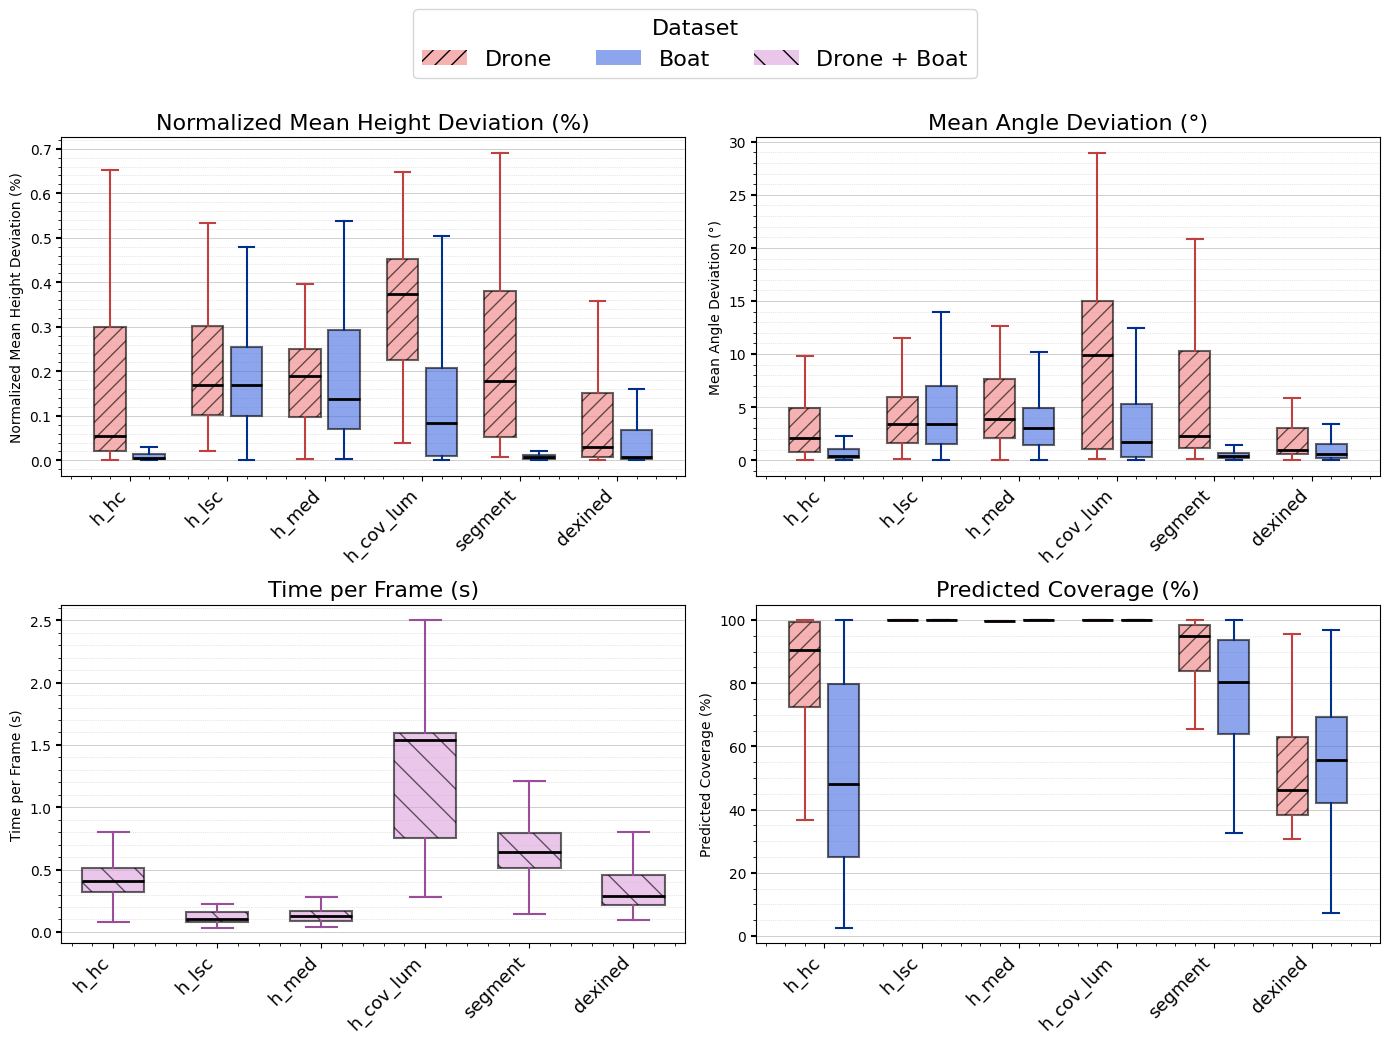

In [28]:
metrics = [
    ("mean_height_perc_dev", "Normalized Mean Height Deviation (%)"),
    ("mean_angle_deviation", "Mean Angle Deviation (°)"),
    ("time_sec", "Time per Frame (s)"),
    ("predicted_coverage_percent", "Predicted Coverage (%)")
]

methods = df_concat['method'].unique()
types = ["drone", "boat"]

box_hatch = {"drone": "//", "boat": ""}
box_colors = {"drone":"lightcoral", "boat": "royalblue"}
whisker_colors = {"drone": "#c04040", "boat": "#002f8c"}

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for ax, (col, ylabel) in zip(axs, metrics):
    x = np.arange(len(methods))
    total_width = 0.8

    for i, m in enumerate(methods):
        if col == "time_sec":
              yvals = df_concat[(df_concat['method']==m)][col].values
              ax.boxplot(
                  yvals,
                  positions=[i],
                  widths=0.6,
                  patch_artist=True,
                  showfliers=False,
                  boxprops=dict(
                      facecolor="plum",
                      hatch="\\",
                      alpha=0.6,
                      linewidth=1.5
                  ),
                  medianprops=dict(color='black', linewidth=2),
                  whiskerprops=dict(color="#9a4d9a", linewidth=1.5),
                  capprops=dict(color="#9a4d9a", linewidth=1.5)
              )
        else:
              separation = total_width / len(types)
              for j, t in enumerate(types):
                  positions = i - total_width/2 + separation/2 + j*separation
                  yvals = df_concat[(df_concat['method']==m) & (df_concat['type']==t)][col].values
                  if len(yvals) == 0:
                      continue
                  ax.boxplot(
                      yvals,
                      positions=[positions],
                      widths=separation*0.8,
                      patch_artist=True,
                      showfliers=False,
                      boxprops=dict(
                          facecolor=box_colors[t],
                          hatch=box_hatch[t],
                          alpha=0.6,
                          linewidth=1.5
                      ),
                      medianprops=dict(color='black', linewidth=2),
                      whiskerprops=dict(color=whisker_colors[t], linewidth=1.5),
                      capprops=dict(color=whisker_colors[t], linewidth=1.5)
                  )

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=13)
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel,fontsize=16)
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.7, alpha=0.6)
    ax.minorticks_on()
    ax.grid(True, which='minor', axis='y', linestyle=':', linewidth=0.5, alpha=0.6)
    ax.tick_params(axis='y', which='major', colors='black', width=1.5, labelsize=10)

legend_handles = [
    mpatches.Patch(
        facecolor=box_colors["drone"],
        hatch="//",
        alpha=0.6,
        label="Drone"
    ),
    mpatches.Patch(
        facecolor=box_colors["boat"],
        alpha=0.6,
        label="Boat"
    ),
    mpatches.Patch(
        facecolor="plum",
        hatch = "\\",
        alpha=0.6,
        label="Drone + Boat"
    )
]

fig.legend(
    handles=legend_handles,
    title="Dataset",
    title_fontsize=16,
    loc='upper center',
    ncol=3,
    fontsize=16,
    bbox_to_anchor=(0.5, 1.05)
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Pairwise Statistical Comparison

We test whether the differences between methods are statistically significant using the **Mann-Whitney U test** for non-parametric data. To control the family-wise error rate when performing multiple comparisons, we apply the **Holm-Bonferroni correction**.

In [29]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

best_methods = ["h_hc", "segment", "dexined", "h_lsc", "h_med", "h_cov_lum"]
metric = "mean_angle_deviation"

for dataset in ["drone", "boat"]:
    print(f"\nDataset: {dataset}")

    pvals = []
    labels = []

    # First pass: compute all raw p-values
    for best in best_methods:
        for other in methods:
            if best == other:
                continue

            group1 = df_concat[(df_concat['type']==dataset) & (df_concat['method']==best)][metric].values
            group2 = df_concat[(df_concat['type']==dataset) & (df_concat['method']==other)][metric].values


            if metric ==  "predicted_coverage_percent":
                stat, p = mannwhitneyu(group1, group2, alternative="greater")
            else:
                stat, p = mannwhitneyu(group1, group2, alternative="less")

            pvals.append(p)
            labels.append((best, other))

    # Apply Holm correction
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='holm')

    # Print results
    for (best, other), raw_p, corr_p, rej in zip(labels, pvals, pvals_corrected, reject):
        sig = "YES" if rej else "no"


        if metric ==  "predicted_coverage_percent":
            print(f"{best} > {other}?  raw p={raw_p:.4g},  Holm p={corr_p:.4g},  significant: {sig}")
        else:
            print(f"{best} < {other}?  raw p={raw_p:.4g},  Holm p={corr_p:.4g},  significant: {sig}")



Dataset: drone
h_hc < h_lsc?  raw p=0.0008805,  Holm p=0.01937,  significant: YES
h_hc < h_med?  raw p=7.681e-05,  Holm p=0.00192,  significant: YES
h_hc < h_cov_lum?  raw p=4.756e-07,  Holm p=1.237e-05,  significant: YES
h_hc < segment?  raw p=0.00222,  Holm p=0.04662,  significant: YES
h_hc < dexined?  raw p=0.9947,  Holm p=1,  significant: no
segment < h_hc?  raw p=0.9978,  Holm p=1,  significant: no
segment < h_lsc?  raw p=0.5124,  Holm p=1,  significant: no
segment < h_med?  raw p=0.3736,  Holm p=1,  significant: no
segment < h_cov_lum?  raw p=0.004169,  Holm p=0.08339,  significant: no
segment < dexined?  raw p=1,  Holm p=1,  significant: no
dexined < h_hc?  raw p=0.005312,  Holm p=0.1009,  significant: no
dexined < h_lsc?  raw p=7.141e-10,  Holm p=2.071e-08,  significant: YES
dexined < h_med?  raw p=5.241e-10,  Holm p=1.572e-08,  significant: YES
dexined < h_cov_lum?  raw p=8.512e-10,  Holm p=2.383e-08,  significant: YES
dexined < segment?  raw p=6.832e-08,  Holm p=1.845e-06,  

# Draw images with predicted horizon for chosen methods

In [30]:
image_folder = "/content/drive/MyDrive/MIUN/QRD/implementation/images"
types = [
    "boat_ice_1", "boat_ice_2", "boat_ice_3",
    "drone_ice_4", "drone_ice_5", "drone_ice_6"
]
num_images_per_type = 3

def get_images_by_pattern(df, pattern, max_n):
    rows = df[df["image_name"].str.contains(pattern, case=False, na=False)]
    return rows.head(max_n)

def draw_horizon(ax, img, x1, y1, x2, y2, title):
    ax.imshow(img)
    ax.plot([x1, x2], [y1, y2], color="red", linewidth=3)
    ax.set_title(title)
    ax.axis("off")

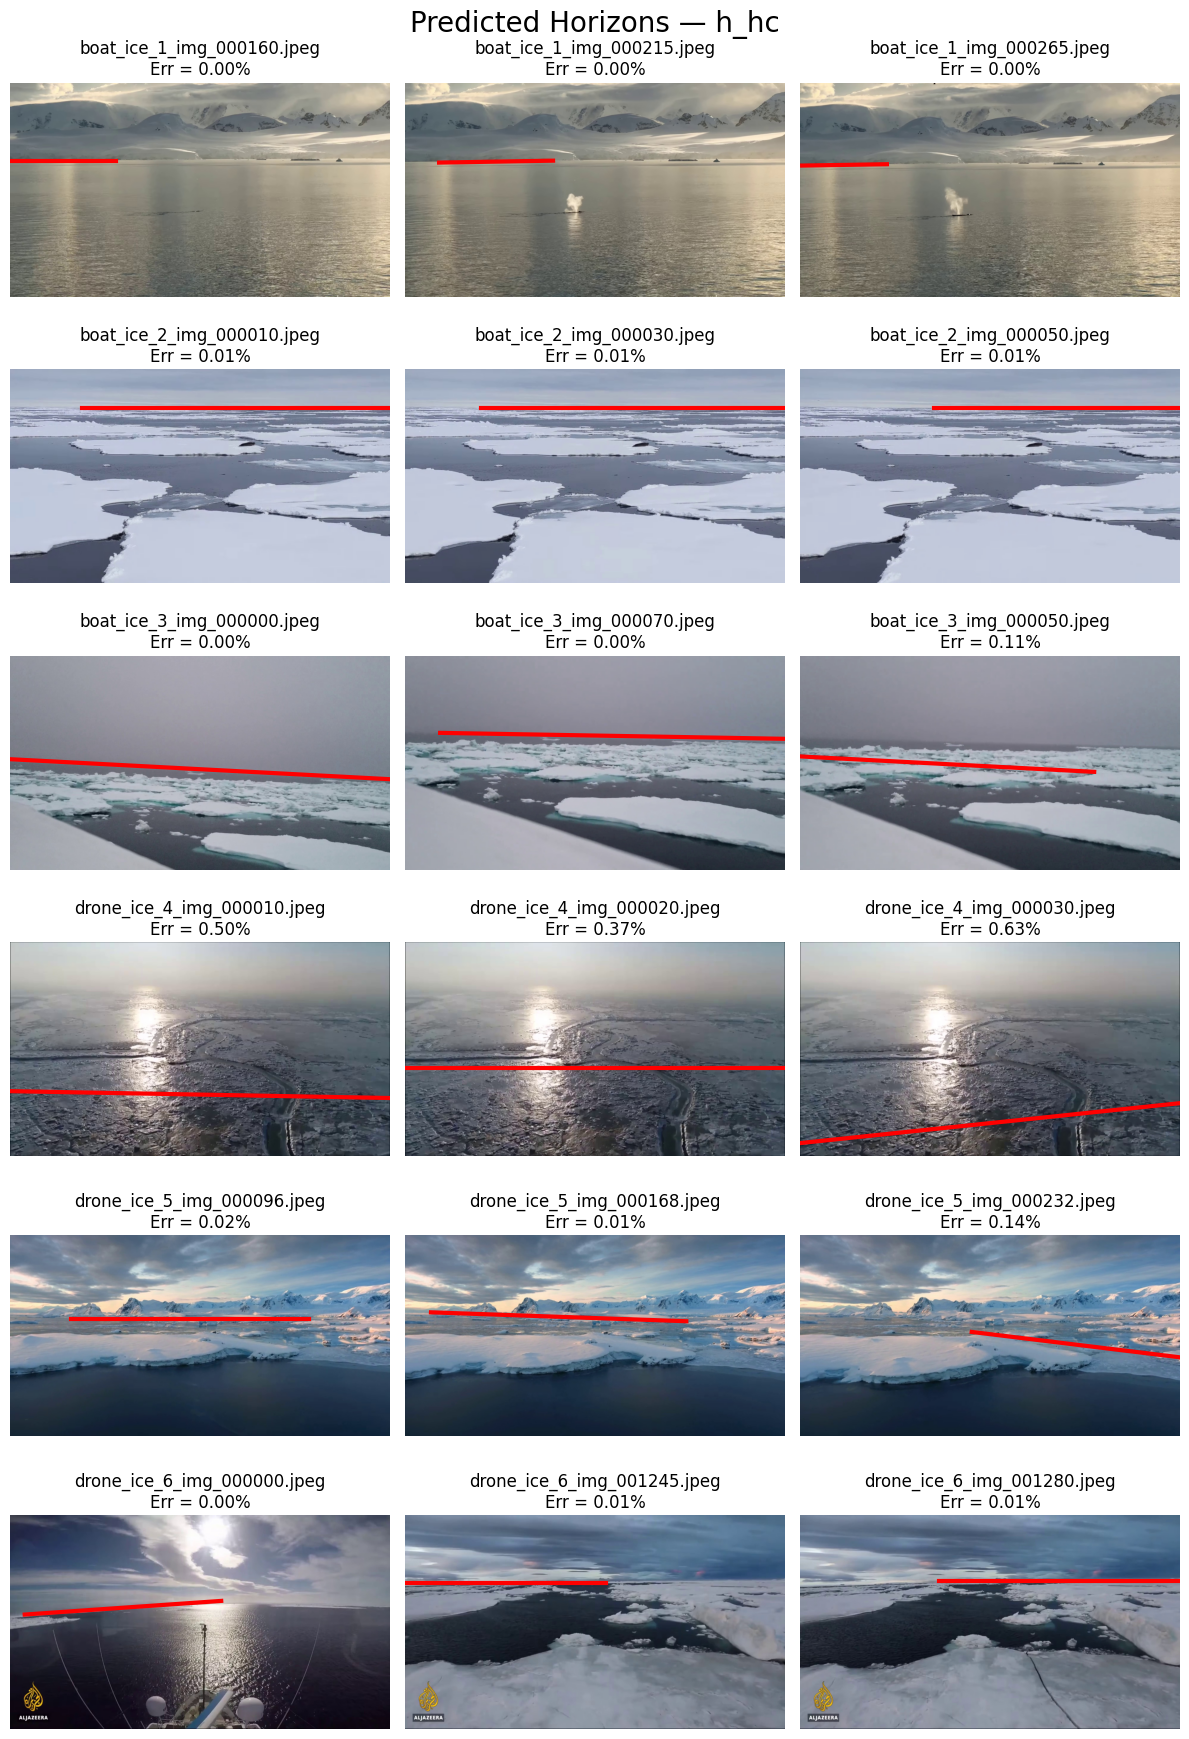

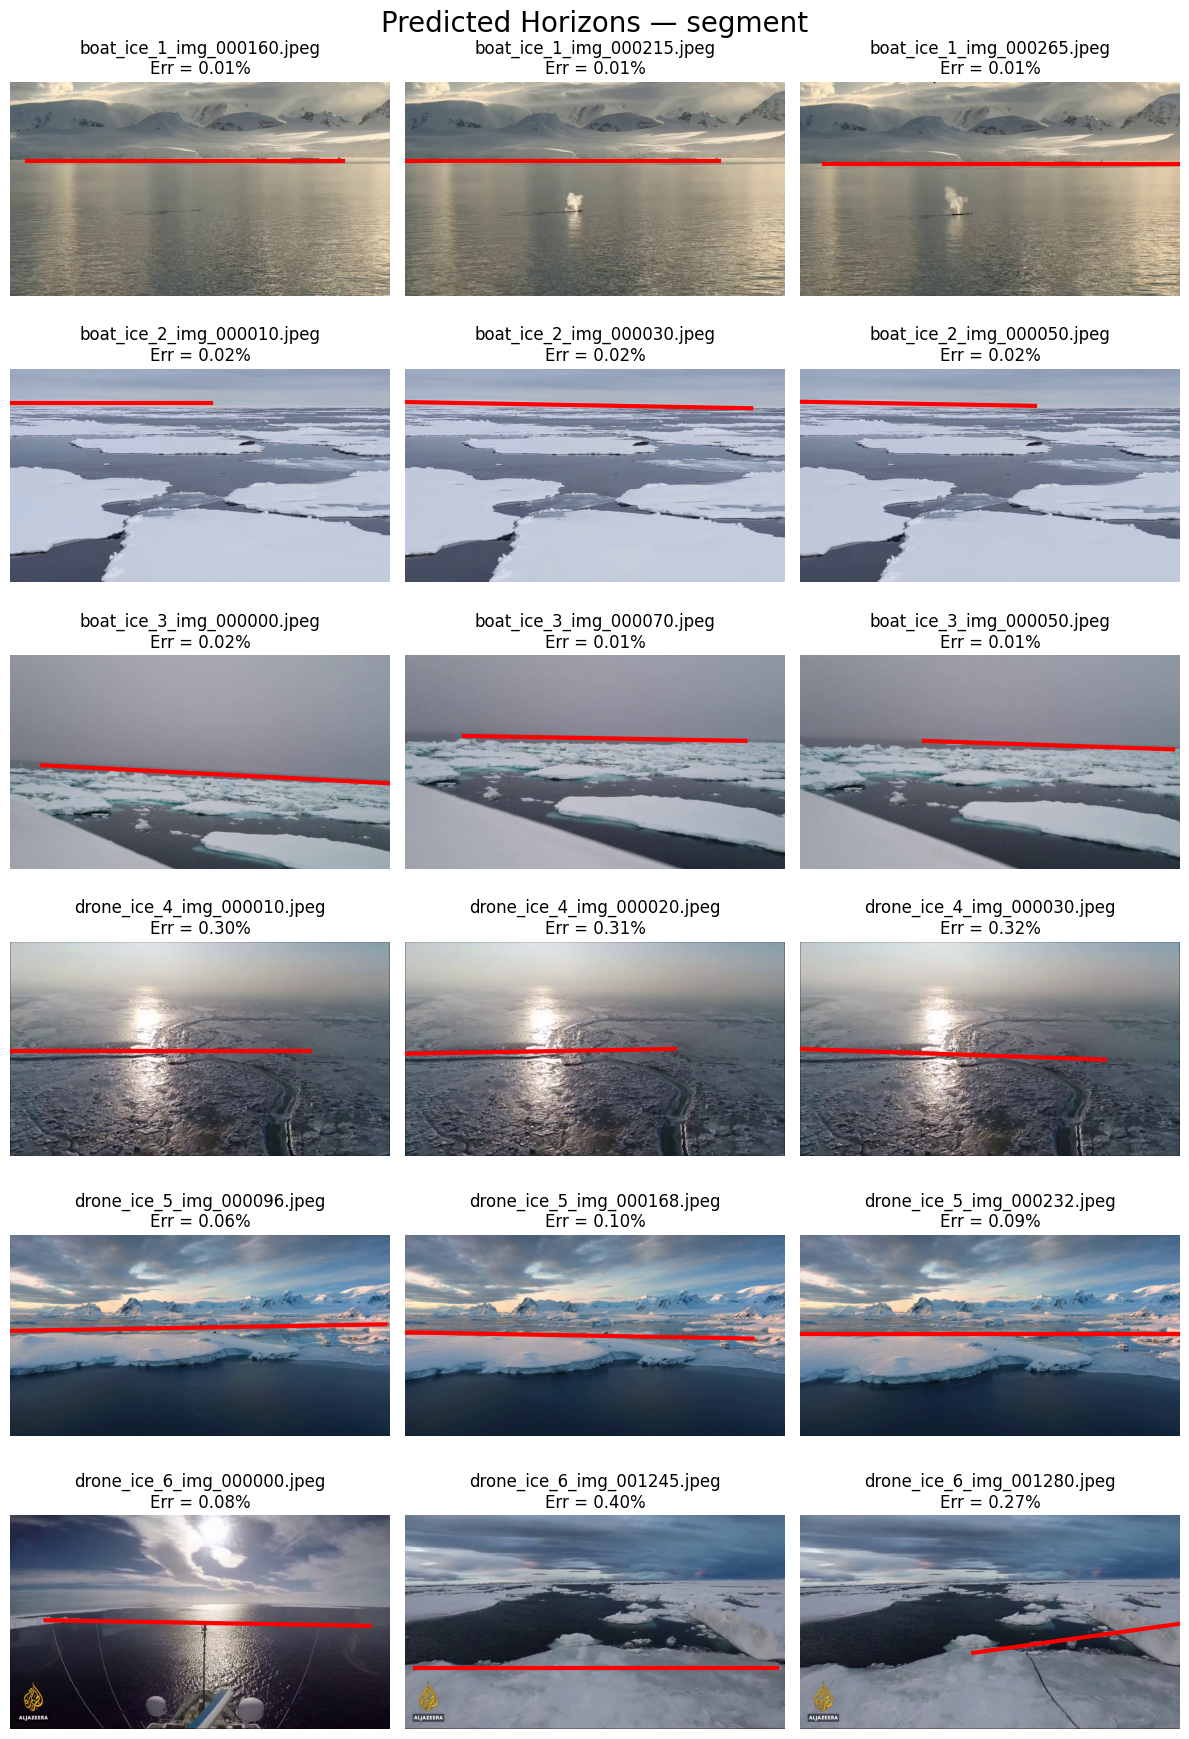

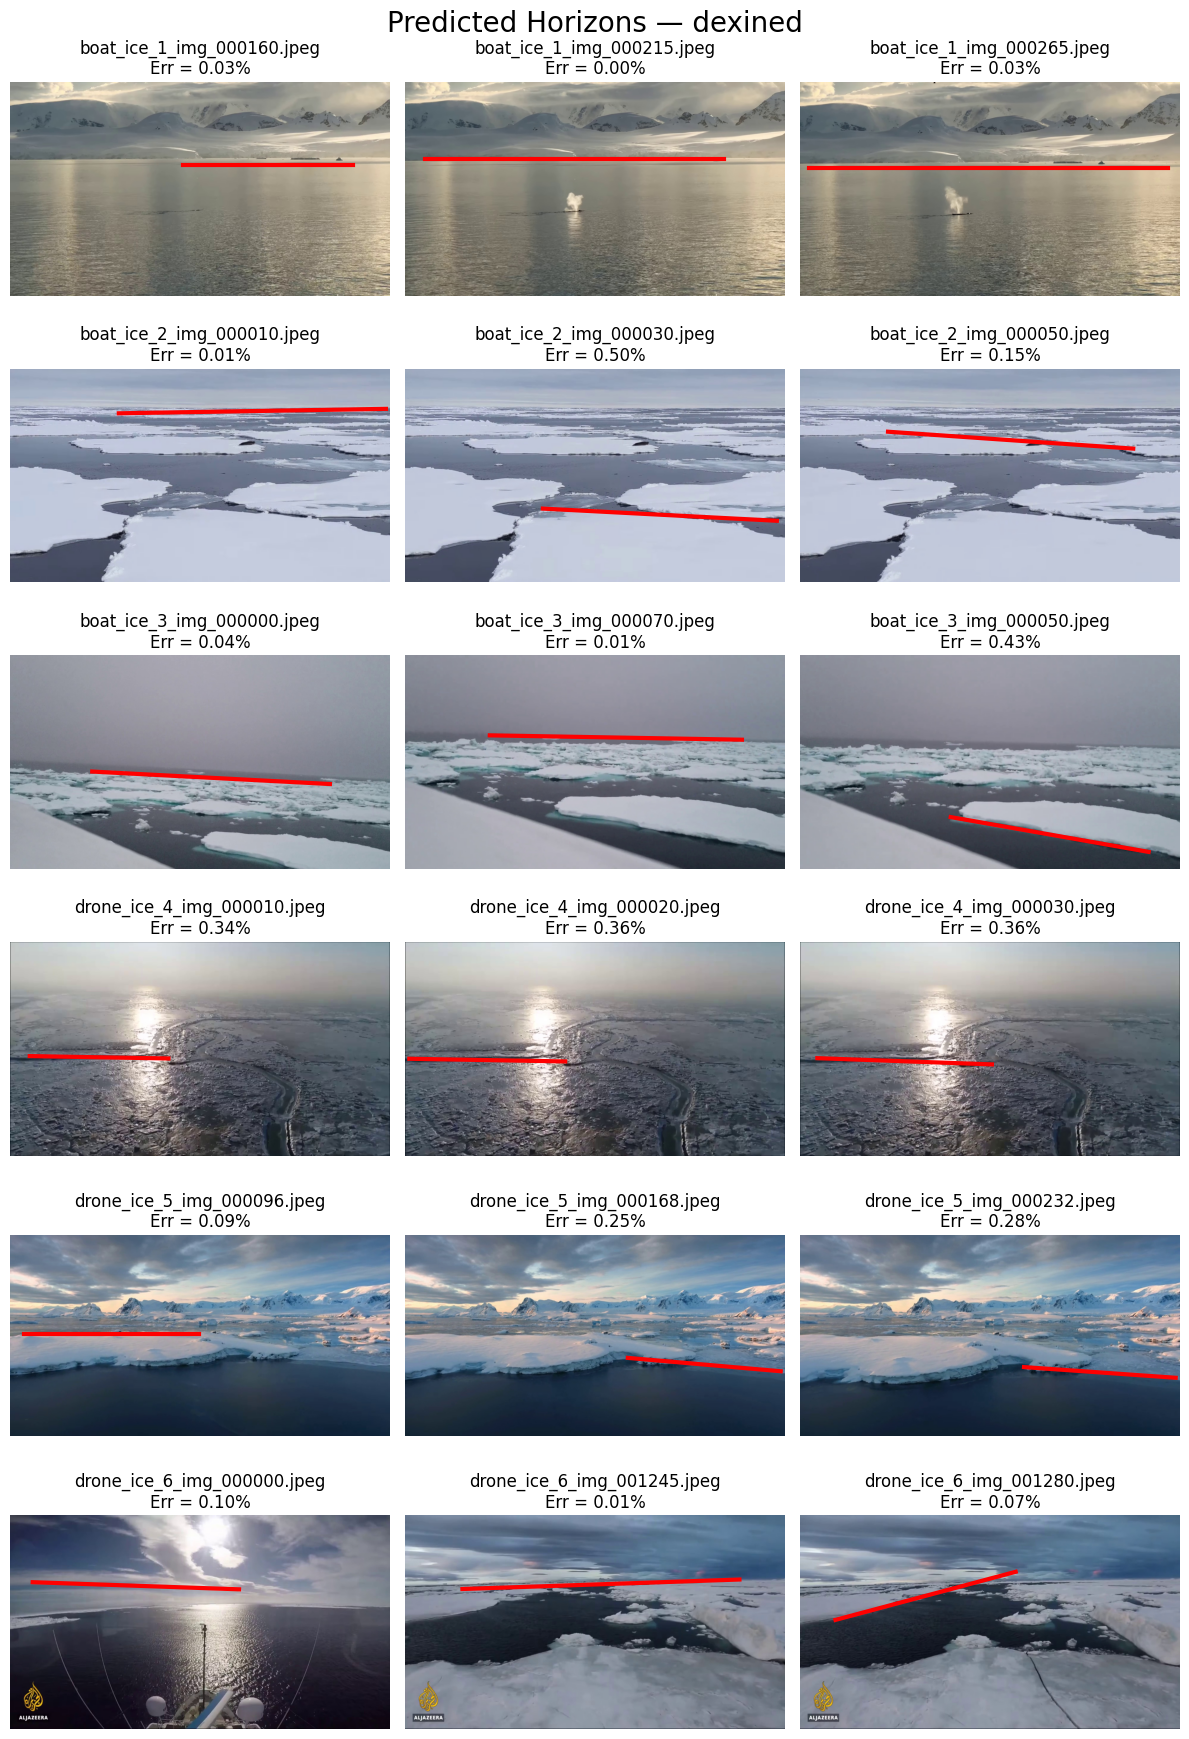

In [32]:
for method_name in ["h_hc", "segment", "dexined"]:

    df = df_pred[method_name]
    df_err = df_analysis_res[method_name]   # analysis results (errors)


    fig, axes = plt.subplots(
        len(types), num_images_per_type,
        figsize=(num_images_per_type * 4, len(types) * 3)
    )
    fig.suptitle(f"Predicted Horizons — {method_name}", fontsize=20)

    for t_idx, t in enumerate(types):
        subset = get_images_by_pattern(df, t, num_images_per_type)

        for i, (_, row) in enumerate(subset.iterrows()):

            img_path = os.path.join(image_folder, row["image_name"])
            if not os.path.exists(img_path):
                print("Missing image:", img_path)
                continue

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            err_row = df_err[df_err["image_name"] == row["image_name"]]
            if len(err_row) > 0:
                err = err_row["mean_height_perc_dev"].iloc[0]
            else:
                err = None

            ax = axes[t_idx, i]
             # Prepare title
            if err is not None:
                title = f"{row['image_name']}\nErr = {err:.2f}%"
            else:
                title = row["image_name"]


            draw_horizon(
                ax, img,
                row["x1"], row["y1"],
                row["x2"], row["y2"],
                title
            )

    plt.tight_layout()
    plt.show()

# Draw gt horizon on one frame from all videos

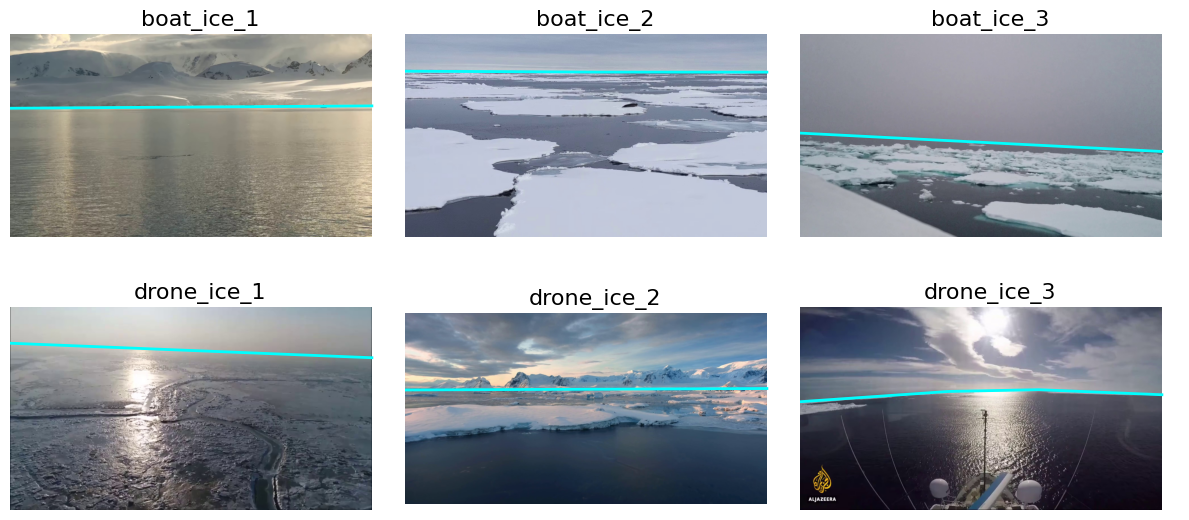

In [34]:
# Paths
images_folder = "/content/drive/MyDrive/MIUN/QRD/implementation/images"
df_path = "/content/drive/MyDrive/MIUN/QRD/implementation/results/horizon_h_hc_analysis_results.csv"
horizon_csv_path = "/content/drive/MyDrive/MIUN/QRD/implementation/horizon_coordinates_all.csv"

# Load CSVs
df = pd.read_csv(df_path)
horizon_df = pd.read_csv(horizon_csv_path)

# Image types
image_types = ['boat_ice_1', 'boat_ice_2', 'boat_ice_3', 'drone_ice_4', 'drone_ice_5', 'drone_ice_6']
plot_labels = ['boat_ice_1', 'boat_ice_2', 'boat_ice_3', 'drone_ice_1', 'drone_ice_2', 'drone_ice_3']

# Collect one sample image per type
sample_images = []
for img_type in image_types:
    filtered = df[df['image_name'].str.contains(img_type)]
    if not filtered.empty:
        img_name = filtered.iloc[0]['image_name']
        img_path = os.path.join(images_folder, img_name)
        if os.path.exists(img_path):
            sample_images.append(img_name)
        else:
            sample_images.append(None)
    else:
        sample_images.append(None)

# Plot images with GT horizon
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()

for i, img_name in enumerate(sample_images):
    axs[i].axis('off')
    axs[i].set_title(plot_labels[i], fontsize=16)

    if img_name is not None:
        img_path = os.path.join(images_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)

        horizon_rows = horizon_df[horizon_df['image_name'] == img_name]
        if not horizon_rows.empty:
            x_vals = horizon_rows['x'].values
            y_vals = horizon_rows['y'].values
            axs[i].plot(x_vals, y_vals, color='cyan', linewidth=2)

plt.tight_layout()
plt.show()